In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
from __future__ import division
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import sys
from IPython.core.display import display, HTML
sns.set_context({'figure.figsize': [12, 7]})
sns.set_context(rc={'lines.markeredgewidth': 0.1})
sns.set_style('white')
sns.set_color_codes()
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import glob
import os
print 'startup script successful'

Populating the interactive namespace from numpy and matplotlib
startup script successful


In [2]:
crunch_data=pd.read_csv('overall_company_list.csv', index_col=0)
kickstart_data=pd.read_csv('proj_list_tech_top200pages_full.csv')
angellist_data=pd.read_csv('results_so_far_2016101710pm.csv', index_col=0)

In [3]:
acq_file_list = glob.glob('cb_acquisitions/*csv')
dfs = []
for f in acq_file_list:
    dfs.append(pd.read_csv(f))
acq_df = pd.concat(dfs, ignore_index=True)
#print acq_df['Acquired Company Name']

In [4]:
cb_cname = crunch_data['Company Name']
acq_cname = acq_df['Acquired Company Name']
print len(set(acq_cname))
print len(set(cb_cname.values) & set(acq_cname.values))

3729
389


In [5]:
# print crunch_data.shape
# print crunch_data.columns
# print acq_df.columns
crunch_data_merged = crunch_data.merge(acq_df, how='left', left_on='Company Name', right_on='Acquired Company Name')
# print crunch_data_merged.shape
# print crunch_data_merged.columns
#crunch_data_merged[crunch_data_merged['Acquired Company Name'].notnull()]

In [6]:
df_dict = dict()
df_dict['cb'] = crunch_data_merged
# df_dict['cb_acq'] = acq_df
df_dict['ks'] = kickstart_data
df_dict['al'] = angellist_data

In [7]:
for key, item in df_dict.iteritems():
    print key, item.shape
    print item.columns

ks (3988, 12)
Index([u'active', u'byline', u'city', u'currency', u'description', u'end_date',
       u'funded_amt', u'funded_pct', u'headline', u'state', u'title', u'url'],
      dtype='object')
cb (11931, 33)
Index([u'Company Name', u'Category Groups', u'Headquarters Location',
       u'Description', u'Crunchbase Rank', u'Founded Date',
       u'Number of Articles', u'Total Equity Funding Amount',
       u'Total Funding Amount', u'Closed Date', u'Categories', u'Status',
       u'Number of Founders', u'Number of Employees', u'Last Funding Date',
       u'Last Funding Amount', u'Last Equity Funding Amount',
       u'Number of Investors', u'IPO Date', u'Money Raised at IPO',
       u'Valuation at IPO', u'Stock Symbol', u'Stock Exchange',
       u'Trend Score (7 Days)', u'Trend Score (30 Days)',
       u'Trend Score (90 Days)', u'Website', u'year', u'Transaction Name',
       u'Acquired Company Name', u'Acquiring Company Name',
       u'Announced On Date', u'Price'],
      dtype='object')

In [8]:
dd=pd.to_datetime(df_dict['al']['joined_date'])
dd.map(lambda x: x.year)

0         2016
1         2016
2         2016
3         2012
4         2012
5         2013
6         2012
7         2012
8         2012
9         2012
10        2015
11        2013
12        2012
13        2012
14        2012
15        2012
16        2013
17        2012
18        2014
19        2014
60        2012
61        2013
62        2015
63        2012
64        2012
65        2013
66        2012
67        2012
68        2011
69        2011
          ... 
309807    2014
309808    2015
309851    2014
309854    2013
309855    2015
309862    2015
309864    2012
309935    2015
309942    2013
309943    2014
309947    2015
310031    2015
310032    2015
310037    2015
310038    2015
310039    2014
310040    2016
328806    2013
328889    2014
328941    2013
329013    2014
329117    2015
329616    2012
334073    2012
334085    2014
352912    2013
357763    2010
357773    2011
358013    2012
363785    2014
Name: joined_date, Length: 6194, dtype: int64

In [9]:
df_dict['ks']['data_source'] = 'kickstarter'
df_dict['ks'].rename(columns={'description':'description', 'title': 'company_name'},inplace=True)

df_dict['cb']['data_source'] = 'crunchbase'
df_dict['cb'].rename(columns={'Description':'description', 'Company Name': 'company_name'},inplace=True)
df_dict['cb']['acquired'] = df_dict['cb']['Acquired Company Name'].notnull().astype(int)

df_dict['al']['data_source'] = 'angellist'
df_dict['al'].rename(columns={'product_desc':'description', 'title': 'company_name'},inplace=True)
df_dict['al']['acquired'] = (df_dict['al']['stage']=='Acquired').astype(int)

In [10]:
for key, item in df_dict.iteritems():
    print key, item.shape
    print item.columns

ks (3988, 13)
Index([u'active', u'byline', u'city', u'currency', u'description', u'end_date',
       u'funded_amt', u'funded_pct', u'headline', u'state', u'company_name',
       u'url', u'data_source'],
      dtype='object')
cb (11931, 35)
Index([u'company_name', u'Category Groups', u'Headquarters Location',
       u'description', u'Crunchbase Rank', u'Founded Date',
       u'Number of Articles', u'Total Equity Funding Amount',
       u'Total Funding Amount', u'Closed Date', u'Categories', u'Status',
       u'Number of Founders', u'Number of Employees', u'Last Funding Date',
       u'Last Funding Amount', u'Last Equity Funding Amount',
       u'Number of Investors', u'IPO Date', u'Money Raised at IPO',
       u'Valuation at IPO', u'Stock Symbol', u'Stock Exchange',
       u'Trend Score (7 Days)', u'Trend Score (30 Days)',
       u'Trend Score (90 Days)', u'Website', u'year', u'Transaction Name',
       u'Acquired Company Name', u'Acquiring Company Name',
       u'Announced On Date', u'

In [11]:
merge_data=pd.concat([x for _, x in df_dict.iteritems()], ignore_index=True)
print merge_data.shape
merge_data.drop_duplicates(inplace=True)
print merge_data.shape

(22113, 56)
(18599, 56)


In [12]:
merge_data.data_source.value_counts()

crunchbase     8417
angellist      6194
kickstarter    3988
Name: data_source, dtype: int64

In [13]:
print merge_data.columns

Index([u'Acquired Company Name', u'Acquiring Company Name',
       u'Announced On Date', u'Categories', u'Category Groups', u'Closed Date',
       u'Crunchbase Rank', u'Founded Date', u'Headquarters Location',
       u'IPO Date', u'Last Equity Funding Amount', u'Last Funding Amount',
       u'Last Funding Date', u'Money Raised at IPO', u'Number of Articles',
       u'Number of Employees', u'Number of Founders', u'Number of Investors',
       u'Price', u'Status', u'Stock Exchange', u'Stock Symbol',
       u'Total Equity Funding Amount', u'Total Funding Amount',
       u'Transaction Name', u'Trend Score (30 Days)', u'Trend Score (7 Days)',
       u'Trend Score (90 Days)', u'Valuation at IPO', u'Website', u'acquired',
       u'active', u'al_link', u'byline', u'city', u'company_name', u'currency',
       u'data_source', u'description', u'end_date', u'featured', u'funded_amt',
       u'funded_pct', u'headline', u'joined_date', u'location', u'market',
       u'raised', u'score', u'signal', u

In [14]:
merge_data_select = merge_data[['company_name', 'description', 'data_source', 'acquired']]

In [15]:
#merge_data_select[merge_data_select['company_name']=='The']
merge_data_select = merge_data_select[(merge_data_select.data_source=='crunchbase') | (merge_data_select.data_source=='angellist')]

In [16]:
#merge_data_select.company_name.value_counts()
merge_data_select = merge_data_select.drop_duplicates()
merge_data_select['description']=merge_data_select['description'].str.replace('\n',' ')
# merge_data['Description']=merge_data['Description'].str.replace('\\',' ')

merge_data_select=merge_data_select.dropna(subset=['description'])

In [17]:
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import sys
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords


token_pattern = re.compile(r"(?u)\b\w\w+\b")
stop_list=stopwords.words('english')+['help','new', 'way', 'world', 'make', 'people']

import itertools
palette = itertools.cycle(sns.hls_palette(15))
markers= itertools.cycle(['x','o','v','^','<','s'])


def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in token_pattern.findall(doc)]
    
def plot_top_words(model, feature_names, topic_idx, n_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
    topic=normalize(model.components_[topic_idx].reshape(1,-1))[0]
    sorted_idx=topic.argsort()[:-n_top_words - 1:-1]
    print("Topic #%d:" % topic_idx)
    features=[feature_names[i] for i in sorted_idx]
    print(" ".join(features))
    ax = sns.barplot(x=range(10),y=topic[sorted_idx])
    feature_id=0
    height= max(topic[sorted_idx])*0.6

    for p in ax.patches:
        ax.text(p.get_x()+0.15, height-0.1, '{}'.format(features[feature_id]))
        feature_id+=1

def plot_cluster(model, features, tsne_features, feature_names, nmf_model):
    """
    model: the clustering model. model.labels_ should contain the clusting label
    features: feature vectors used to compute the clustering centroid
    tsne_features: feature vectors for plot with tsne
    """
    cluster_labels=model.labels_
    n_top_words=10
    num_clusters=max(cluster_labels)+1
    cluster_name=[]
    # plotting
    # sample 2000 data points for scattering plot
    sample_for_plt, label_for_plt=resample(tsne_features,cluster_labels,n_samples=2000,random_state=0)
    mapping = TSNE(n_components=2,init='random', random_state=0, n_iter=2000, verbose=0, learning_rate=100, perplexity=20)
    embed=mapping.fit_transform(sample_for_plt)
    fig=figure(figsize=(15,7))
    # plot the clusters
    subplot(1,2,1)
    for i in range(num_clusters):
        subgroup=embed[label_for_plt==i,:]
        scatter(subgroup[:,0],subgroup[:,1],s=15, color=next(palette), marker=next(markers), label='{}'.format(i))
    legend()
    # plot the histgram of the clusters 
    subplot(1,2,2)
    hist(cluster_labels)
    # print out the cluster centers
    fig=figure(figsize=(15,10))
    for i in range(max(cluster_labels)+1):
        cluster=features[cluster_labels==i,:]
        centroid=np.mean(cluster,axis=0)
        centroid_feature=centroid.dot(nmf_model.components_)
        sorted_idx=centroid_feature.argsort()[:-n_top_words - 1:-1]
        c_name=' '.join([feature_names[j] for j in sorted_idx[:3]])
        cluster_name.append(c_name)
        subplot(num_clusters,1,i+1)
        ax = sns.barplot(x=range(10),y=centroid_feature[sorted_idx])
        top_words=[feature_names[j] for j in sorted_idx]
        word_id=0
        height= max(centroid_feature[sorted_idx])*0.6
        for p in ax.patches:
            ax.text(p.get_x()+0.15, height, '{}'.format(top_words[word_id]))
            word_id+=1
    return cluster_name

def print_cluster_member(model, cluster_id, data, num_samples=10):
    cluster_member=data.iloc[model.labels_==cluster_id]
    print 'number of companies in this class:', len(cluster_member)
    for m in cluster_member.head(num_samples).iterrows():
        print 'company ID:', m[0]
        print m[1]['Description']

def cluster_companies(df_data, description_column_name, num_clusters):
    """
    df_data: company dataframe
    description_column_name: column name of the dataframe corresponding to company description
    num_clusters: number of clusters 
    """
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2,
                                       max_features=3000,
                                       tokenizer=LemmaTokenizer(),
                                       stop_words=stop_list)
    tfidf = tfidf_vectorizer.fit_transform(df_data[description_column_name])
    nmf = NMF(n_components=15, random_state=1, 
              alpha=.1, l1_ratio=.2, max_iter=5000).fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    topic_feature=nmf.transform(tfidf)
    topic_feature_norm=normalize(topic_feature)
    agg= AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    agg.fit(topic_feature_norm)
    df_data['cluster_id']=agg.labels_
    cluster_name= plot_cluster(agg, topic_feature, topic_feature_norm, tfidf_feature_names, nmf)
    df_data['cluster_name']= df_data['cluster_id'].apply(lambda x: cluster_name[x])

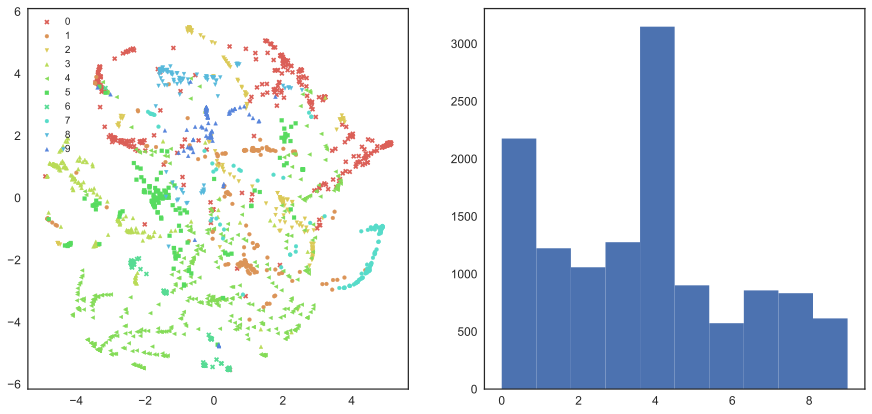

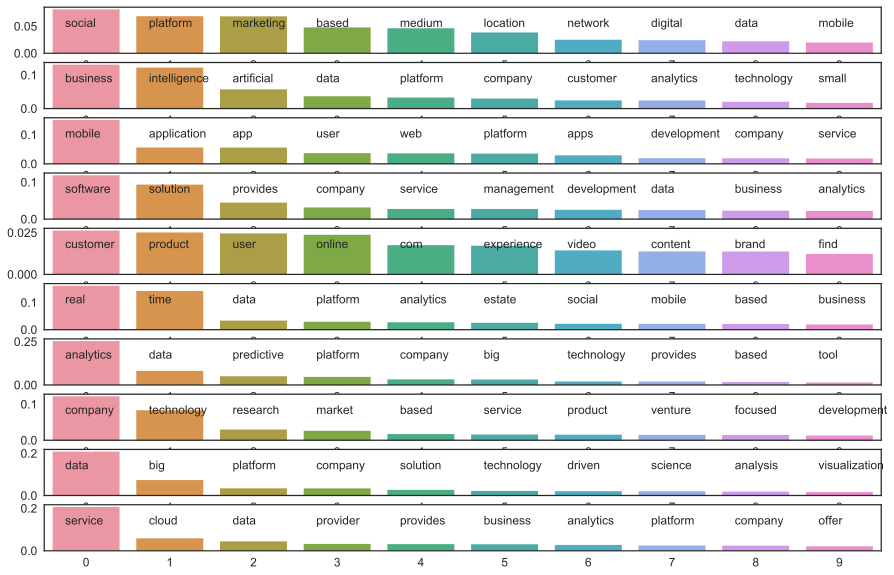

In [18]:
cluster_companies(df_data=merge_data_select, description_column_name='description', num_clusters=10)

In [19]:
merge_data_select.columns

Index([u'company_name', u'description', u'data_source', u'acquired',
       u'cluster_id', u'cluster_name'],
      dtype='object')

In [20]:
merge_data_select

,company_name,description,data_source,acquired,cluster_id,cluster_name
3988,Krux,"Krux helps marketers, publishers and agencies ...",crunchbase,1.0,0,social platform marketing
3989,Datadog,Datadog is the essential monitoring service fo...,crunchbase,0.0,9,service cloud data
3990,Sumo Logic,"Sumo Logic, a log management and analytics ser...",crunchbase,0.0,1,business intelligence artificial
3991,Quid,Quid powers human intuition with machine intel...,crunchbase,0.0,1,business intelligence artificial
3992,Vicarious,Vicarious develops Recursive Cortical Network™...,crunchbase,0.0,4,customer product user
3993,"Alteryx, Inc.",Alteryx is the leader in self-service data ana...,crunchbase,0.0,9,service cloud data
3994,PlaceIQ,PlaceIQ provides location intelligence service...,crunchbase,0.0,1,business intelligence artificial
3995,Qubit,Qubit gives marketers the tools to understand ...,crunchbase,0.0,5,real time data
3996,Euclid Analytics,Euclid Analytics is the world leader in locati...,crunchbase,0.0,6,analytics data predictive
3997,Infer,Infer provides a predictive SaaS platform that...,crunchbase,0.0,1,business intelligence artificial


In [21]:
df1 = merge_data_select.groupby('cluster_name')['acquired'].sum()
#df1['count'] = merge_data_select.groupby('cluster_name').count()

In [22]:
df1

cluster_name
analytics data predictive            49.0
business intelligence artificial     74.0
company technology research          43.0
customer product user               277.0
data big platform                    57.0
mobile application app              111.0
real time data                       78.0
service cloud data                   39.0
social platform marketing           152.0
software solution provides           75.0
Name: acquired, dtype: float64

In [23]:
df2 = merge_data_select.groupby('cluster_name')['acquired'].count()

In [24]:
print df2

cluster_name
analytics data predictive            572
business intelligence artificial    1223
company technology research          857
customer product user               3148
data big platform                    833
mobile application app              1058
real time data                       901
service cloud data                   614
social platform marketing           2176
software solution provides          1276
Name: acquired, dtype: int64


In [25]:
acq_ratio = (df1/df2)*100

In [26]:
print acq_ratio

cluster_name
analytics data predictive            8.566434
business intelligence artificial     6.050695
company technology research          5.017503
customer product user                8.799238
data big platform                    6.842737
mobile application app              10.491493
real time data                       8.657048
service cloud data                   6.351792
social platform marketing            6.985294
software solution provides           5.877743
Name: acquired, dtype: float64
